In [3]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

In [4]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y : 2


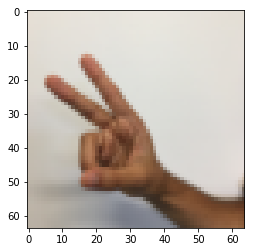

In [5]:
index = 6
plt.imshow(X_train_orig[index])
print('y : '+str(np.squeeze(Y_train_orig[0,index])))

In [6]:
X_train_orig.shape,Y_train_orig.shape

((1080, 64, 64, 3), (1, 1080))

#### Pre-processing data

In [7]:
#flattening training images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0],-1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0],-1).T
X_test_flatten.shape
#normalizing image vectors
x_train = X_train_flatten/255
x_test = X_test_flatten/255
#converting to one hot matrices
y_train = convert_to_one_hot(Y_train_orig,6)
y_test = convert_to_one_hot(Y_test_orig,6)

print ("number of training examples = " + str(x_train.shape[1]))
print ("number of test examples = " + str(x_test.shape[1]))
print ("x_train shape: " + str(x_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("x_test shape: " + str(x_test.shape))
print ("y_test shape: " + str(y_test.shape))

number of training examples = 1080
number of test examples = 120
x_train shape: (12288, 1080)
y_train shape: (6, 1080)
x_test shape: (12288, 120)
y_test shape: (6, 120)


In [8]:
def create_placeholders(n_x,n_y):
    x = tf.placeholder(tf.float32, shape=(n_x, None), name = 'X')
    y = tf.placeholder(tf.float32, shape=(n_y, None), name = 'Y')
    return x,y

In [9]:
x,y = create_placeholders(12288,6)
print('x: '+ str(x))
print('y: '+ str(y))

x: Tensor("X:0", shape=(12288, ?), dtype=float32)
y: Tensor("Y:0", shape=(6, ?), dtype=float32)


W = tf.get_variable(name, shape=None, dtype=tf.float32, initializer=None,
       regularizer=None, trainable=True, collections=None)

#### Initiaization

In [10]:
nodes = [12288,25,12,6]
def initialize_parameters():
    tf.set_random_seed(1)
    L = len(nodes)
    parameters = {}
    for i in range(1,L):
        parameters['w' + str(i)] = tf.get_variable('w'+str(i),[nodes[i],nodes[i-1]],
                             initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        parameters['b' + str(i)] = tf.get_variable('b'+str(i),[nodes[i],1],
                             initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        
    return parameters

In [49]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
print(parameters)

{'w1': <tf.Variable 'w1:0' shape=(25, 12288) dtype=float32_ref>, 'b1': <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>, 'w2': <tf.Variable 'w2:0' shape=(12, 25) dtype=float32_ref>, 'b2': <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>, 'w3': <tf.Variable 'w3:0' shape=(6, 12) dtype=float32_ref>, 'b3': <tf.Variable 'b3:0' shape=(6, 1) dtype=float32_ref>}


#### Forward Propagation

In [11]:
def forward_propagation(x,parameters):
    #reterieve params
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    w3 = parameters['w3']
    b3 = parameters['b3']
    
    z1 = tf.matmul(w1,x)+b1
    a1 = tf.nn.relu(z1)
    z2 = tf.matmul(w2,a1)+b2
    a2 = tf.nn.relu(z2)
    z3 = tf.matmul(w3,a2)+b3
    #no need for a3 since last linear layer is given as
    #input function for computing loss
    return z3

In [59]:
tf.reset_default_graph()
with tf.Session() as sess:
    x,y = create_placeholders(12288,6)
    parameters = initialize_parameters()
    z3  = forward_propagation(x,parameters)
    print('z3'+str(z3))

z3Tensor("add_2:0", shape=(6, ?), dtype=float32)


The "logits" and "labels" inputs of tf.nn.softmax_cross_entropy_with_logits are expected to be of shape (number of examples, num_classes)

In [12]:
def compute_cost(z3,y):#(logits,labels)
    logits = tf.transpose(z3)
    labels = tf.transpose(y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits,labels = labels))
    return cost

In [61]:
tf.reset_default_graph()
with tf.Session() as sess:
    x,y = create_placeholders(12288,6)
    parameters = initialize_parameters()
    z3  = forward_propagation(x,parameters)
    cost = compute_cost(z3,y)
    print(cost)

Tensor("Mean:0", shape=(), dtype=float32)


In [21]:
def model(x_train,y_train,x_test,y_test,
          learning_rate = 0.0001,num_epochs = 1000,
           mini_batch_size = 32,print_cost = True):
    ops.reset_default_graph()
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3
    n_x,m = x_train.shape
    n_y = y_train.shape[0]
    costs = []
    
    x,y = create_placeholders(n_x,n_y)
    parameters = initialize_parameters()
    z3 = forward_propagation(x,parameters)
    
    cost = compute_cost(z3,y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            epoch_cost = 0
            num_minibatches = int(m/mini_batch_size)
            seed = seed + 1
            minibatches = random_mini_batches(x_train,y_train,mini_batch_size,seed)
            for minibatch in minibatches:
                
                #select a minibatch
                minibatch_x, minibatch_y = minibatch
                _,mini_batch_cost = sess.run([optimizer,cost],feed_dict = {x:minibatch_x
                                                                           ,y:minibatch_y})
                epoch_cost += mini_batch_cost/num_minibatches
            
            if print_cost =='True' and epoch%50 ==0:
                print('Cost after epoch'+str(epoch)+' is '+ str(epoch_cost))
            if print_cost =='True' and epoch%5 ==0:
                costs.append(epoch_cost)
        plt.plot(np.squeeze(costs))
        plt.ylabel('Costs')
        plt.xlabel('Iterations')
        plt.title('Learninig rate')
        plt.show()
        
        #to save parameters
        parameters = sess.run(parameters)
        
        #calculate correct prediction
        correct_prediction = tf.equal(tf.argmax(z3),tf.argmax(y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,'float'))
        
        print('Train Accuracy: ',accuracy.eval({x:x_train, y : y_train}))
        print('Test Accuracy: ',accuracy.eval({x:x_test, y : y_test}))
        
        return parameters

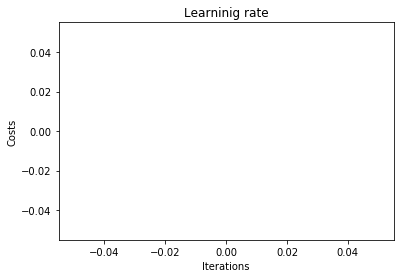

Train Accuracy:  1.0
Test Accuracy:  0.85


In [22]:
parameters = model(x_train, y_train, x_test, y_test)

In [36]:
def predict(X, parameters):
    
    w1 = tf.convert_to_tensor(parameters["w1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    w2 = tf.convert_to_tensor(parameters["w2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    w3 = tf.convert_to_tensor(parameters["w3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"w1": w1,
              "b1": b1,
              "w2": w2,
              "b2": b2,
              "w3": w3,
              "b3": b3}
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [37]:
def forward_propagation_for_predict(x, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    w3 = parameters['w3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(w1, x), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(w2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(w3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3
    

c:\python36\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys
c:\python36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


Your algorithm predicts: y = 3


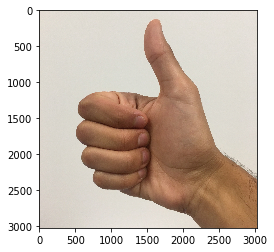

In [74]:
import scipy
from PIL import Image
from scipy import ndimage

my_image = "thumbs_up.jpg"
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

'1'

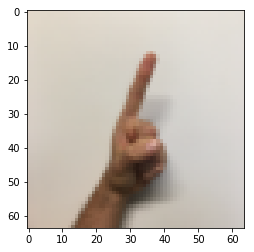

In [73]:
index = 7  #wrong at 107
plt.imshow(X_test_orig[index])
my_image_prediction = predict(x_test[:,index].reshape(12288,1), parameters)
str(np.squeeze(my_image_prediction))